<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bot de consulta abierta y respuestas predeterminadas con DNN + Spacy

### 1 - Instalar dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [59]:
import json
import string
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [3]:
# descargaremos un pipeline de pre-procesamiento de SpaCy en español
!python -m spacy download es_core_news_sm

2023-11-11 19:18:10.971558: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-11 19:18:10.971618: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-11 19:18:10.971654: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-11 19:18:11.979752: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 70.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [60]:
# cargar pipeline de pre-procesamiento en español
import spacy
nlp = spacy.load("es_core_news_sm")

### 2 - Herramientas de preprocesamiento de datos
Entre las tareas de procesamiento de texto en español se implementa:
- Quitar acentos y caracteres especiales
- Quitar números
- Quitar símbolos de puntuación

In [61]:
import re
import unicodedata

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):
    # Antes de preprocesar los datos se pasa a minúsculas todo el texto
    text = text.lower()
    # sacar tildes de las palabras:
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' # [^ : ningún caracter de todos estos
    # (termina eliminando cualquier caracter distinto de los del regex)
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' # igual al anterior pero sin cifras numéricas
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

### 3 - Diccionario de entrada

In [62]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
# Los "patterns" van a formar el corpus para entrenar el clasificador que clasifica en tags
# "respones" son las respuestas predeterminadas posibles para cada tag
dataset = {"intents": [
             {"tag": "bienvenida",
              "patterns": ["Hola", "¿Cómo estás?", "¿Qué tal?"],
              "responses": ["Hola!", "Hola, ¿Cómo estás?"],
             },
             {"tag": "nombre",
              "patterns": ["¿Cúal es tu nombre?", "¿Quién sos?"],
              "responses": ["Mi nombre es RecomiendaBot", "Yo soy el Bot de recomendación de películas"]
             },
            {"tag": "acción",
              "patterns": ["acción", "suspenso", "películas", "crimenes", "policial"],
              "responses": ["Claro , puedo recomendarte peliculas de acción", "Puedo recomendarte una película de suspenso"]
             },
            {"tag": "comedia",
              "patterns": ["¿Me recomendas una película cómica?", "¿Qué película graciosa puedo ver?"],
              "responses": ["Si, aquí te comparto un listado de películas del género comedia <lista>"]
             },
            {"tag": "edad",
              "patterns": ["edad","menores","La pelicula es apta para todo público?", "¿Cuál es la edad mínima para ver la película?", "¿La pueden ver menores?"],
              "responses": ["Las peliculas que te recomiendo son aptas para todo público"]
             },
            {"tag": "guerra",
              "patterns": ["guerra", "disparos", "bomba","invasión" , "armas"],
              "responses": ["Aquí te comparto un listado de películas bélicas <link>"]
             },
            {"tag": "románticas",
              "patterns": ["Recomendame películas románticas", "romance", "amor"],
              "responses": ["Aquí tienes una lista de películas románticas"]
             },
            {"tag": "puntaje",
              "patterns": [ "rating", "puntaje" , "calificación"],
              "responses": ["Aquí te paso las películas recomendadas ordenadas por rating"]
             },
             {"tag": "despedida",
              "patterns": [ "Chau", "Hasta luego!", "gracias"],
              "responses": ["Por nada", "Adios"]
             }
]}

### 4 - Preprocesamiento y armado del dataset

In [63]:
# Datos que necesitaremos, las palabras o vocabulario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterizan
# a esa intención y transformarla a tokens para almacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)
# En `words` vamos a guardar el vocabulario
# En `class` las posibles clases o tags

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern))
        # lematizar los tokens
        for token in tokens:
            words.append(token.lemma_)

        doc_X.append(pattern)
        doc_y.append(intent["tag"])

    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocabulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

In [64]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['accion', 'amor', 'apto', 'arma', 'bomba', 'calificacion', 'chau', 'comico', 'como', 'crimen', 'cual', 'dispar', 'edad', 'el', 'este', 'gracias', 'gracioso', 'guerra', 'hasta', 'holar', 'invasion', 'luego', 'menor', 'minimo', 'nombre', 'para', 'pelicula', 'pelicular', 'poder', 'policial', 'publico', 'puntaje', 'que', 'quien', 'rating', 'recomendame', 'recomendas', 'romance', 'romantica', 'ser', 'so', 'suspenso', 'tal', 'todo', 'tu', 'uno', 'ver', 'yo', 'él']
classes: ['acción', 'bienvenida', 'comedia', 'despedida', 'edad', 'guerra', 'nombre', 'puntaje', 'románticas']
doc_X: ['Hola', '¿Cómo estás?', '¿Qué tal?', '¿Cúal es tu nombre?', '¿Quién sos?', 'acción', 'suspenso', 'películas', 'crimenes', 'policial', '¿Me recomendas una película cómica?', '¿Qué película graciosa puedo ver?', 'edad', 'menores', 'La pelicula es apta para todo público?', '¿Cuál es la edad mínima para ver la película?', '¿La pueden ver menores?', 'guerra', 'disparos', 'bomba', 'invasión', 'armas', 'Recomendam

In [65]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))

Vocabulario: 49


In [66]:
# Cantidad de tags
print("Tags:", len(classes))

Tags: 9


In [106]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:


        bow.append(1) if word in text else bow.append(0)

    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)

# Dividir en datos de entrada y salida para train
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))


X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 0, 1, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 0, 1, 0, 0]
X: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### 5 - Entrenamiento del modelo

In [107]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (49,) output: 9


In [108]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam

from keras.layers import Dense, Dropout, Embedding, Flatten

model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 128)               6400      
                                                                 
 dropout_30 (Dropout)        (None, 128)               0         
                                                                 
 dense_46 (Dense)            (None, 64)                8256      
                                                                 
 dropout_31 (Dropout)        (None, 64)                0         
                                                                 
 dense_47 (Dense)            (None, 9)                 585       
                                                                 
Total params: 15241 (59.54 KB)
Trainable params: 15241 (59.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [109]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
#Agrego una capa de embeddings a la entrada

from keras.layers import Dense, Dropout, Embedding, Flatten

model_emb = Sequential()
model_emb.add(Embedding(input_dim=len(words), output_dim=512, input_length=input_shape[0]))
model_emb.add(Flatten())
model_emb.add(Dense(128, input_shape=input_shape, activation="relu"))
model_emb.add(Dropout(0.5))
model_emb.add(Dense(64, activation="relu"))
model_emb.add(Dropout(0.5))
model_emb.add(Dense(output_shape, activation = "softmax"))

model_emb.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model_emb.summary())

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 49, 512)           25088     
                                                                 
 flatten_10 (Flatten)        (None, 25088)             0         
                                                                 
 dense_48 (Dense)            (None, 128)               3211392   
                                                                 
 dropout_32 (Dropout)        (None, 128)               0         
                                                                 
 dense_49 (Dense)            (None, 64)                8256      
                                                                 
 dropout_33 (Dropout)        (None, 64)                0         
                                                                 
 dense_50 (Dense)            (None, 9)               

In [110]:
#Entreno el modelo sin embeddings
hist = model.fit(x=train_X, y=train_y, epochs=200)

Epoch 1/200
1/1 [==============================] - 1s 581ms/step - loss: 2.2324 - accuracy: 0.0968
Epoch 2/200
1/1 [==============================] - 0s 8ms/step - loss: 2.2289 - accuracy: 0.1290
Epoch 3/200
1/1 [==============================] - 0s 9ms/step - loss: 2.2390 - accuracy: 0.1290
Epoch 4/200
1/1 [==============================] - 0s 9ms/step - loss: 2.2317 - accuracy: 0.1290
Epoch 5/200
1/1 [==============================] - 0s 9ms/step - loss: 2.1667 - accuracy: 0.0968
Epoch 6/200
1/1 [==============================] - 0s 10ms/step - loss: 2.2159 - accuracy: 0.0645
Epoch 7/200
1/1 [==============================] - 0s 9ms/step - loss: 2.1857 - accuracy: 0.1290
Epoch 8/200
1/1 [==============================] - 0s 8ms/step - loss: 2.1474 - accuracy: 0.1290
Epoch 9/200
1/1 [==============================] - 0s 8ms/step - loss: 2.2071 - accuracy: 0.1290
Epoch 10/200
1/1 [==============================] - 0s 10ms/step - loss: 2.1293 - accuracy: 0.1290
Epoch 11/200
1/1 [=======

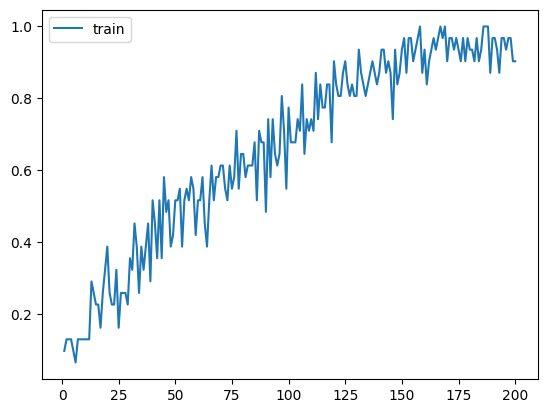

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')

plt.show()

In [112]:
#Entreno el modelo con embeddings
hist = model_emb.fit(x=train_X, y=train_y, epochs=200)

Epoch 1/200
1/1 [==============================] - 1s 666ms/step - loss: 2.1984 - accuracy: 0.0645
Epoch 2/200
1/1 [==============================] - 0s 44ms/step - loss: 2.6595 - accuracy: 0.0645
Epoch 3/200
1/1 [==============================] - 0s 37ms/step - loss: 2.3532 - accuracy: 0.2258
Epoch 4/200
1/1 [==============================] - 0s 36ms/step - loss: 2.3168 - accuracy: 0.0968
Epoch 5/200
1/1 [==============================] - 0s 39ms/step - loss: 2.2207 - accuracy: 0.1613
Epoch 6/200
1/1 [==============================] - 0s 31ms/step - loss: 2.2507 - accuracy: 0.0968
Epoch 7/200
1/1 [==============================] - 0s 31ms/step - loss: 2.2110 - accuracy: 0.2258
Epoch 8/200
1/1 [==============================] - 0s 32ms/step - loss: 2.1551 - accuracy: 0.0645
Epoch 9/200
1/1 [==============================] - 0s 31ms/step - loss: 2.2634 - accuracy: 0.1290
Epoch 10/200
1/1 [==============================] - 0s 31ms/step - loss: 2.1819 - accuracy: 0.1290
Epoch 11/200
1/1 [

In [113]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# En NLP además de los modelos es necesario proveer: tokenizador y vocabulario.
# La tríada modelo+tokenizador+vocabulario es necesaria para hacer inferencia.
# Sin una de las tres no se puede hacer inferencia.

# en este caso guardamos:
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
#Guardo el modelo sin embedding
model.save('chatbot_model.h5')

#Guardo el modelo con embedding
model_emb.save('chatbot_model_emb.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### 6 - Testing y validación

In [114]:
# convertir texto de entrada del usuario a tokens
def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

# transformar el texto de entrada tokenizado a una representación OHE
def bag_of_words(text, vocab):
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens:
        for idx, word in enumerate(vocab):
            if word == w:
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

# usar modelo con la entrada en OHE y los labels posibles (tags)
def pred_class(text, vocab, labels):
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0: # sólo si reconoció alguna palabra del vocabulario
        result = model.predict(np.array([bow]))[0] # es un array de softmax
        thresh = 0.4
        # filtrar aquellas entradas menores al umbral `thresh`
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        # ordenar keys de acuerdo al valor softmax
        y_pred.sort(key=lambda x: x[1], reverse=True)

        # return_list es una lista de los labels de mayor a menor
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    # si no reconoció palabras del vocabulario se devuelve una lista vacía
    return return_list

def pred_class_emb(text, vocab, labels):
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0: # sólo si reconoció alguna palabra del vocabulario
        result = model_emb.predict(np.array([bow]))[0] # es un array de softmax
        thresh = 0.4
        # filtrar aquellas entradas menores al umbral `thresh`
        y_pred_emb = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        # ordenar keys de acuerdo al valor softmax
        y_pred_emb.sort(key=lambda x: x[1], reverse=True)

        # return_list es una lista de los labels de mayor a menor
        for r in y_pred_emb:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    # si no reconoció palabras del vocabulario se devuelve una lista vacía
    return return_list


# obtener una respuesta predeterminada
def get_response(intents_list, intents_json):
    tag = intents_list[0] # tomar el tag con el mejor valor softmax
    list_of_intents = intents_json["intents"] # intents_json es todo el dataset
    for i in list_of_intents:
        if i["tag"] == tag: # buscar el tag correspoindiente y dar una respuesta predeterminada aleatoria
            result = random.choice(i["responses"])
            break
    return result

In [137]:
#Testeo bot de RN sin embedding
while True:
    # pedir input al usuario
    message = input("")
    print("Q:", message)

    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print("BOT:", result)
    else: # si no hubo ningún resultado que supere el umbral
        print("BOT: Perdón, no comprendo la pregunta.")


tu identidad?
Q: tu identidad?
1/1 [==============================] - 0s 18ms/step
BOT: Perdón, no comprendo la pregunta.
Cual es tu identidad?
Q: Cual es tu identidad?
1/1 [==============================] - 0s 30ms/step
BOT: Yo soy el Bot de recomendación de películas
Recomendame peliculas sobre enamoramientos
Q: Recomendame peliculas sobre enamoramientos
1/1 [==============================] - 0s 21ms/step
BOT: Aquí tienes una lista de películas románticas
y alguna pelicula sobre investigación de un hecho delictivo?
Q: y alguna pelicula sobre investigación de un hecho delictivo?
1/1 [==============================] - 0s 23ms/step
BOT: Puedo recomendarte una película de suspenso
Y una pelicula sobre conflictos armados entre naciones?
Q: Y una pelicula sobre conflictos armados entre naciones?
1/1 [==============================] - 0s 14ms/step
BOT: Puedo recomendarte una película de suspenso
BOT: Puedo recomendarte una película de suspenso No, una película sobre conflictos armados
Q: BO

KeyboardInterrupt: ignored

In [136]:
#Testeo bot de RN con embedding
while True:
    # pedir input al usuario
    message = input("")
    print("Q:", message)

    intents = pred_class_emb(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print("BOT:", result)
    else: # si no hubo ningún resultado que supere el umbral
        print("BOT: Perdón, no comprendo la pregunta.")

tu identidad?
Q: tu identidad?
1/1 [==============================] - 0s 18ms/step
BOT: Yo soy el Bot de recomendación de películas
Recomendame peliculas sobre enamoramientos
Q: Recomendame peliculas sobre enamoramientos
1/1 [==============================] - 0s 17ms/step
BOT: Aquí tienes una lista de películas románticas
y alguna pelicula sobre investigación de un hecho delictivo?
Q: y alguna pelicula sobre investigación de un hecho delictivo?
1/1 [==============================] - 0s 20ms/step
BOT: Claro , puedo recomendarte peliculas de acción
Y una pelicula sobre conflictos armados entre naciones?
Q: Y una pelicula sobre conflictos armados entre naciones?
1/1 [==============================] - 0s 15ms/step
BOT: Puedo recomendarte una película de suspenso
No, una película sobre conflictos armados
Q: No, una película sobre conflictos armados
1/1 [==============================] - 0s 16ms/step
BOT: Claro , puedo recomendarte peliculas de acción
Sobre guerras
Q: Sobre guerras
1/1 [====

KeyboardInterrupt: ignored

FileNotFoundError: ignored

### 7 - Conclusiones
El bot puede responder a preguntas si y solo si se utilizan dentro de las preguntas las palabras clave. Esto se puso de manifiesto al solicitar la recomendación de una comedia debiendo repetir la pregunta hasta usar la palabra "graciosa" que si estaba dentro de los patterns.El modelo es simple y no puede capturar relaciones latentes entre palabras (sinónimos, por ejemplo). Supongo que usando words embeddings la performance deberia mejorar.
